<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Intro" data-toc-modified-id="Intro-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Intro</a></span><ul class="toc-item"><li><span><a href="#Evaluating-Causal-Models" data-toc-modified-id="Evaluating-Causal-Models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Evaluating Causal Models</a></span></li><li><span><a href="#One-Weird-Trick:-Aggregate-on-$x$" data-toc-modified-id="One-Weird-Trick:-Aggregate-on-$x$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>One Weird Trick: Aggregate on $x$</a></span></li></ul></li><li><span><a href="#Fitting-Models" data-toc-modified-id="Fitting-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fitting Models</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predictions</a></span></li><li><span><a href="#Misc-Thoughts" data-toc-modified-id="Misc-Thoughts-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Misc Thoughts</a></span></li></ul></div>

@dzhang203
2022-05

[Book Ref: Chapter 19](https://matheusfacure.github.io/python-causality-handbook/19-Evaluating-Causal-Models.html)

# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

/home/daz/hello_world/tell_me_why/env/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Intro

## Evaluating Causal Models
The goal of a simple causal model is to understand the effect of some treatment $t$ on some outcome $y$, conditional on covariates $x$, i.e. $\frac{\partial y}{\partial t}(t|x)$.

How do we know that a causal model is effectively capturing that true derivative? In academic settings and learning exercises (like this one!), we can generate synthetic data from some DGP where we _know_ the real $\frac{\partial y}{\partial t}(t|x)$--by generating multiple counterfactual outcomes for the same $x$--and see how well our estimated $\hat{\frac{\partial y}{\partial t}}(t|x)$ predicts the true treatment effects.

However, in reality, we won't have different $y$'s for the same $x$ at different intervention levels $t$.

## One Weird Trick: Aggregate on $x$
If $x$ is atomic, then you're never going to have different $y$'s for the same $x$ at different intervention levels $t$. But if you condition on $x$ that includes multiple observation units, then you'll actually be able to observe $\frac{\partial y}{\partial t}(t|x)$!

Note that this is only going to be possible if the variation in $t|x$ is actually exogenous. (Note to self: if it's not, maybe estimate a model to orthogonalize it? Or, manually extract out the random (wiggle) component?)

# Fitting Models

We load data from [github:matheusfacure/python-causality-handbook/data](https://github.com/matheusfacure/python-causality-handbook/tree/master/causal-inference-for-the-brave-and-true/data):

In [2]:
prices = pd.read_csv('../data/ice_cream_sales.csv')  # loads non-exogenous data
prices_exog = pd.read_csv('../data/ice_cream_sales_rnd.csv')  # loads exogenous (DGP'd) data
print(prices.shape)
print(prices_exog.shape)
prices_exog.head()


(10000, 5)
(5000, 5)


,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


The first model we'll train will be a linear regression with interactions so that elasticity can vary between units:

$$ sales_i = \beta_0 + \beta_1 price_i + \beta_2 X_i + \beta_3 X_i price_i + \epsilon_i $$

After fitting this model, we'll be able to make elasticity predictions:

$$ \hat{ \frac{\partial sales}{\partial price}}(price_i, X_i) = \hat{\beta_2} + \hat{\beta_3} X_i $$

Refer to [statsmodels formulas examples](https://www.statsmodels.org/stable/example_formulas.html) if needed; below, the \* operator also includes the individual columns that were multiplied together. 

In [3]:
m1 = smf.ols("sales ~ price*temp + price*C(weekday) + price*temp", data=prices).fit()

Next, we'll train a fully nonparametrics, predicted machine learning model:

$$ sales_i = G(price_i, X_i) + \epsilon_i $$

In [5]:
X = [
    'temp',
    'weekday',
    'cost',
    'price'
]
y = 'sales'

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y])

GradientBoostingRegressor()

One check on the model is to computed its $R^2$ using `.score()`. If $R^2$ doesn't just drop a bit, but rather falls off a cliff, on the test data, then we've probably overfit:

In [6]:
print('Train Score:', m2.score(prices[X], prices[y]))
print('Test Score:', m2.score(prices_exog[X], prices_exog[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


# Predictions
We're going to look at the estimated marginal effects using an approximation:

$$ \frac{\partial y}{\partial price}(price, X) \approx \frac{y(price + h, X) - y(price, X)}{h} $$

Just so we have everything in one place, we'll add the predicted marginal effects to a single dataframe.

In [36]:
def predict_marginal_effect(model, price_df, h=2.0):
    return (model.predict(price_df.assign(price=price_df['price']+h/2))
            - model.predict(price_df.assign(price=price_df['price']-h/2))) / h

np.random.seed(123)
prices_exog_pred = prices_exog.assign(**{
    'ols_slope_pred': predict_marginal_effect(m1, prices_exog[X]),  # ols
    'ml_slope_pred': predict_marginal_effect(m2, prices_exog[X]),  # gradient boosting regressor
    'random_slope_pred': np.random.uniform(size=prices_exog.shape[0]),  # random model
})
prices_exog_pred.head()

,temp,weekday,cost,price,sales,ols_slope_pred,ml_slope_pred,random_slope_pred
0,25.8,1,0.3,7,230,-13.556769,-8.756083,0.696469
1,22.7,3,0.5,4,190,1.222003,-3.962999,0.286139
2,33.7,7,1.0,5,237,-16.658933,-6.897218,0.226851
3,23.0,4,0.5,5,193,0.646474,-2.416491,0.551315
4,24.4,1,1.0,3,252,-13.013002,-4.191300,0.719469


<AxesSubplot:xlabel='ols_slope_pred', ylabel='Count'>

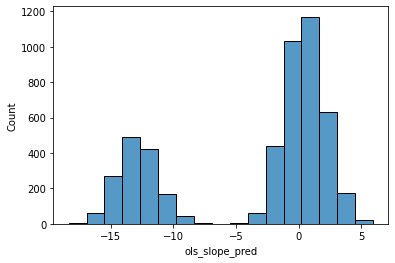

In [37]:
sns.histplot(prices_exog_pred['ols_slope_pred'])

<AxesSubplot:xlabel='ml_slope_pred', ylabel='Count'>

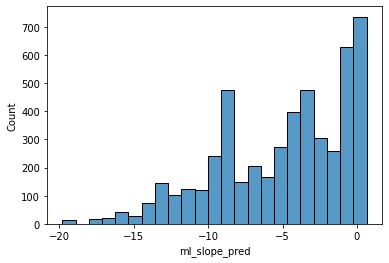

In [38]:
sns.histplot(prices_exog_pred['ml_slope_pred'])

Already we see that it's not trivial to get marginal value predictions from the GBT, at least for single points $X$. If we set, e.g. `h=0.01` above, the regression model can still give us marginal effects, but the GBT will give us lots of 0 effect estimates, since we'll be gathering predictions at two nearby values of `price` between which there isn't a split.

# Misc Thoughts

Looking ahead in Ch. 19, Matheus suggests plotting cumulative elasticity curves. What this means is, we're going to collect the estimated elasticities by groups $x$, sort them into high-to-low groups, and then visually see how well-ordered they are. Additionally, we're going to look at how heterogeneous the treatment effects really are, which should give us insight into how much headroom we can actually get from personalization.

However--not covered in Matheus's material--the fundamental model evaluation should still come from looking error in the predicted elasticities themselves. And in this case, we should try to get a test sample with exogenous variation and group them (and potentially orthogonalize the treatment variable) in order to obtain elasticity estimates.